In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


/Users/prc-222/PycharmProjects/AI/otus/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("german_credit_data.csv")
df.columns = df.columns.str.strip()

for c in ["Unnamed: 0", "index"]:
    if c in df.columns:
        df = df.drop(columns=[c])

df = df.replace({"NA": np.nan, "N/A": np.nan, "nan": np.nan})

df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


## EDA

Анализируем:
- размерность,
- типы данных,
- количество пропусков,
- распределения числовых признаков,
- самые частые категории для категориальных признаков.


In [3]:
print("Shape:", df.shape)
df.dtypes


Shape: (1000, 9)


Age                 int64
Sex                   str
Job                 int64
Housing               str
Saving accounts       str
Checking account      str
Credit amount       int64
Duration            int64
Purpose               str
dtype: object

In [4]:
# проверяем сколько пустот
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Checking account    394
Saving accounts     183
dtype: int64

### Разделим признаки на числовые и категориальные

- числовые: Age, Job, Credit amount, Duration
- категориальные: Sex, Housing, Saving accounts, Checking account, Purpose


In [5]:
num_cols = ["Age", "Job", "Credit amount", "Duration"]
cat_cols = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]

## Анализ числовых характеристик

In [6]:
df[num_cols].describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


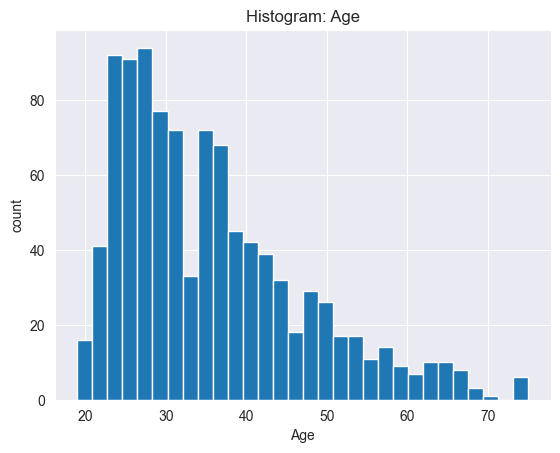

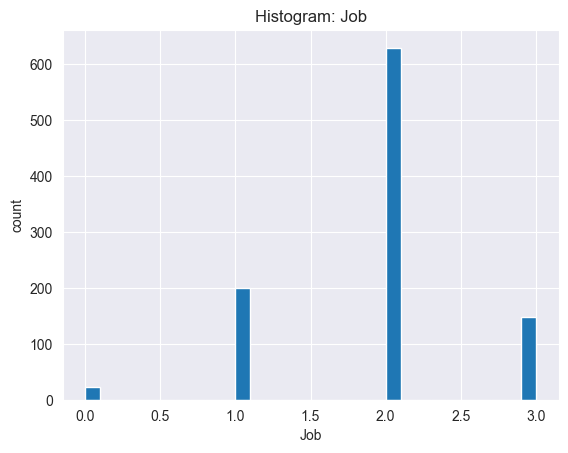

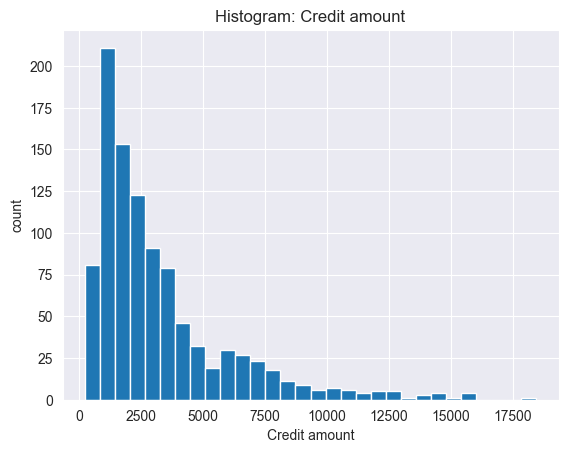

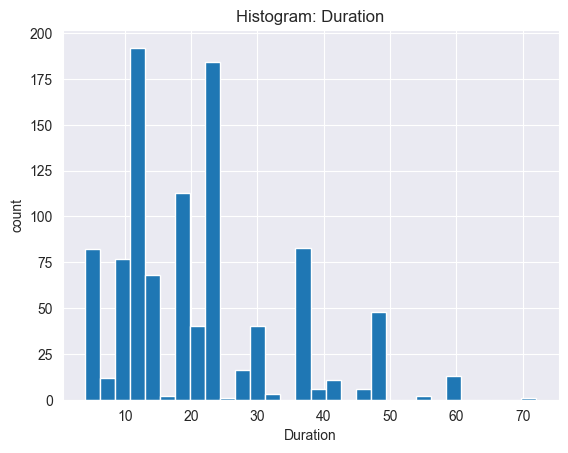

In [7]:
for col in num_cols:
    plt.figure()
    df[col].dropna().hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()


## Категориальные признаки


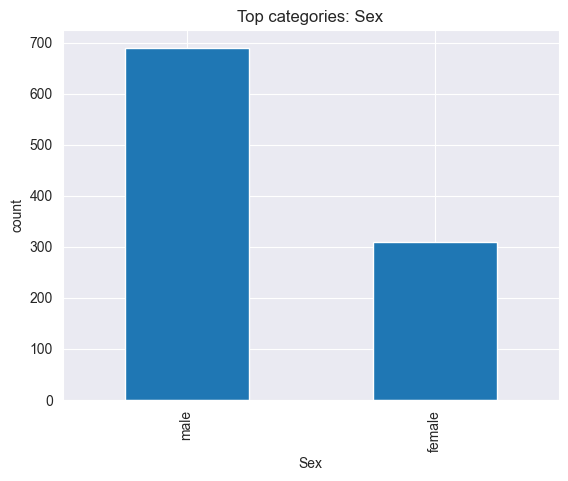

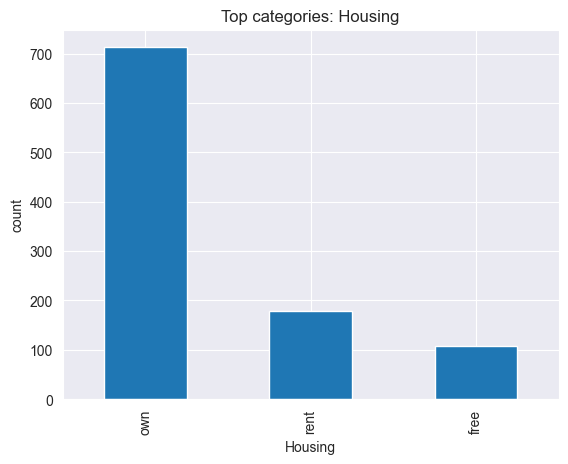

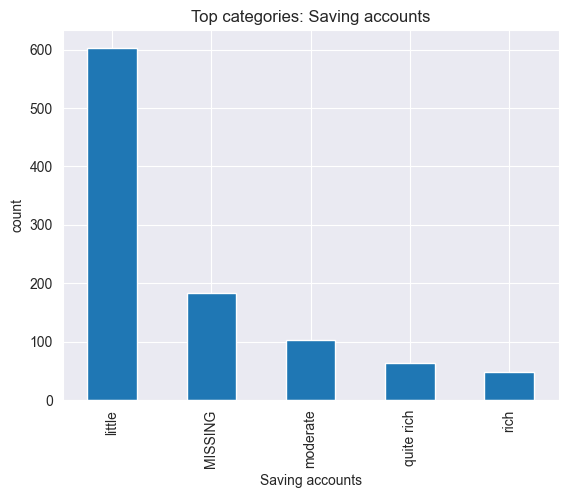

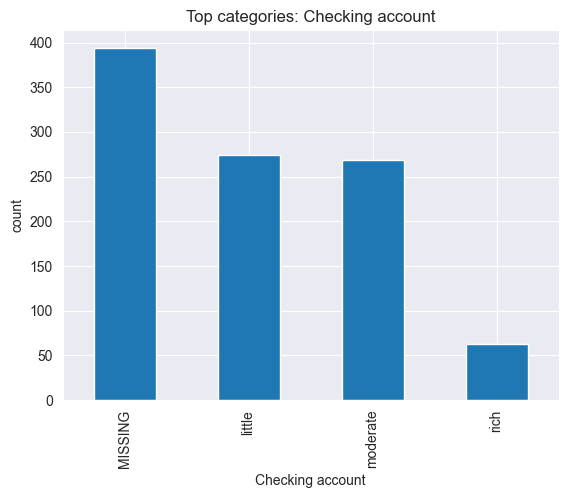

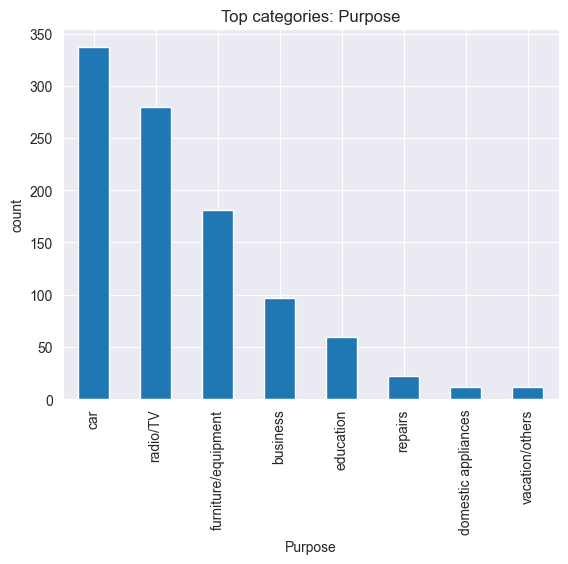

In [8]:
for col in cat_cols:
    vc = df[col].astype("string").fillna("MISSING").value_counts().head(15)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Top categories: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()


## Preprocessing - конвертация категориальных признаков в числовые + скейлинг числовых

### Зачем скейлинг?
- **K-Means**: основан на евклидовом расстоянии до центроидов,
- **Ward Agglomerative**: объединение кластеров по критерию на основе расстояний,
- **DBSCAN**: плотность в эспселон окрестности

Все вышеперечисленные алгоритмы основаны на расстоянии, если наши данные будут в разных масштабах, то кластеризация будет некорректной, поэтому необходимо приводить признаки к общему масштабу.

### Кодируем категориальные признаки
- Для категорий используем OneHotEncoding
- Для пропусков:
  - для категорий: заполним most_frequent
  - для числовых: заполним медианой.
- Для числовых характеристик используем MinMax


In [9]:
# копируем датасет
X = df[num_cols + cat_cols].copy()

# пайплайн преобразования для числовых признаков
numeric_pipe = Pipeline(steps=[
    # imputer заполняет пропуски средним
    ("imputer", SimpleImputer(strategy="median")),
    # скейлер приводит признаки к одному масштабу
    ("scaler", MinMaxScaler()),
])

# пайплайн преобразования для карегориальных признаков
categorical_pipe = Pipeline(steps=[
    # imputer заполняет пустоты наиболее часто встречающейся категорией
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # one применяет алгоритм oneHotEncoding к признакам
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    # указываем наши пайплайны для признаков
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    # остальные столбцы дропаем
    remainder="drop",
)

prep_and_scale = Pipeline(steps=[
    ("prep", preprocess),
])

X_enc = prep_and_scale.fit_transform(X)
X_enc


array([[0.85714286, 0.66666667, 0.05056674, ..., 1.        , 0.        ,
        0.        ],
       [0.05357143, 0.66666667, 0.31368989, ..., 1.        , 0.        ,
        0.        ],
       [0.53571429, 0.33333333, 0.10157368, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.33928571, 0.66666667, 0.03048311, ..., 1.        , 0.        ,
        0.        ],
       [0.07142857, 0.66666667, 0.08776274, ..., 1.        , 0.        ,
        0.        ],
       [0.14285714, 0.66666667, 0.23803235, ..., 0.        , 0.        ,
        0.        ]], shape=(1000, 24))

## Сжатие пространства перед кластеризацией

Используем алгоритмы алгоритмы PCA, UMAP, tSNE для уменьшения размерности и проанализируем графики.


/Users/prc-222/PycharmProjects/AI/otus/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


PCA2: (1000, 2) UMAP2: (1000, 2) TSNE2: (1000, 2)


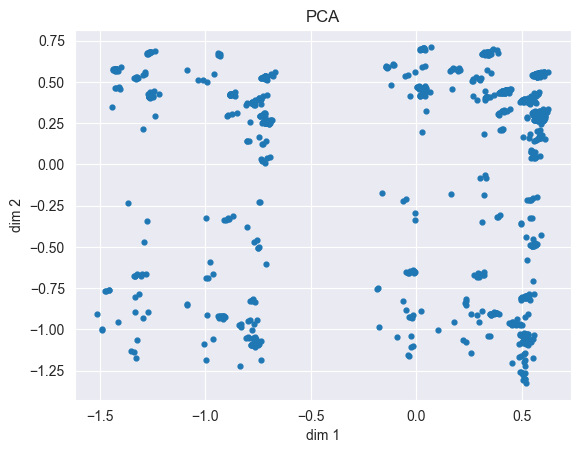

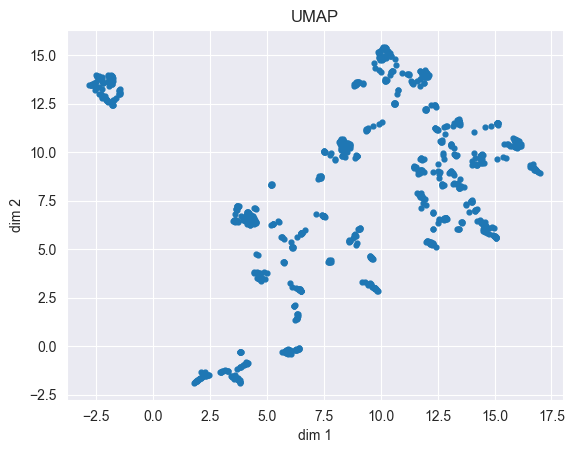

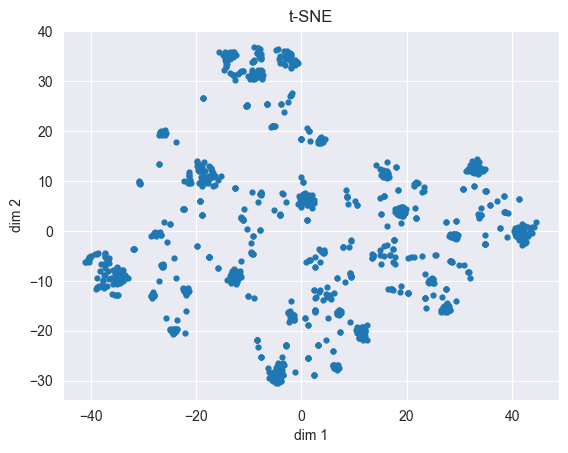

In [10]:
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_enc)

umap2 = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
)
X_umap2 = umap2.fit_transform(X_enc)

tsne2 = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
X_tsne2 = tsne2.fit_transform(X_enc)

print("PCA2:", X_pca2.shape, "UMAP2:", X_umap2.shape, "TSNE2:", X_tsne2.shape)

def plot_2d(X2, title):
    plt.figure()
    plt.scatter(X2[:, 0], X2[:, 1], s=12)
    plt.title(title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.show()

plot_2d(X_pca2, "PCA")
plot_2d(X_umap2, "UMAP")
plot_2d(X_tsne2, "t-SNE")

## Анализ полученных графиков
- PCA - тяжело отличимы кластеры, линейное разделение неочевидно - кластеры разделены нелинейно
- UMAP - заметное улучшение по сравнению в PCA, выявляет плотные группы кластеров
- tSNE - заметна большая сегментация кластеров по сравнению с UMAP

## Подбор параметров и обучение моделей кластеризации

In [11]:
def safe_silhouette(Xd, labels):
    labels = np.asarray(labels)
    uniq = set(labels.tolist())
    if len(uniq) < 2:
        return None

    if -1 in uniq:
        mask = labels != -1
        if mask.sum() < 3:
            return None
        if len(set(labels[mask].tolist())) < 2:
            return None
        return silhouette_score(Xd[mask], labels[mask])

    return silhouette_score(Xd, labels)


## Кластеризация



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

def safe_silhouette(X, labels):
    labels = np.asarray(labels)
    uniq = set(labels.tolist())
    if len(uniq) < 2:
        return None
    if -1 in uniq:
        mask = labels != -1
        if mask.sum() < 3 or len(set(labels[mask].tolist())) < 2:
            return None
        return silhouette_score(X[mask], labels[mask])

    return silhouette_score(X, labels)

def eval_kmeans(X, k_min=2, k_max=12):
    ks = list(range(k_min, k_max + 1))
    inertias, sils = [], []
    best = None

    for k in ks:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        s = safe_silhouette(X, labels)
        sils.append(s if s is not None else np.nan)
        if s is not None and (best is None or s > best[1]):
            best = (k, s)

    return {
        "best_k": None if best is None else best[0],
        "best_silhouette": None if best is None else best[1],
        "ks": ks,
        "inertias": inertias,
        "sils": sils,
    }

def eval_agglo(X, k_min=2, k_max=12):
    ks = list(range(k_min, k_max + 1))
    sils = []
    best = None

    for k in ks:
        agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = agg.fit_predict(X)
        s = safe_silhouette(X, labels)
        sils.append(s if s is not None else np.nan)
        if s is not None and (best is None or s > best[1]):
            best = (k, s)

    return {
        "best_k": None if best is None else best[0],
        "best_silhouette": None if best is None else best[1],
        "ks": ks,
        "sils": sils,
    }

def eval_dbscan(X, eps_grid=None, min_samples_grid=(5, 10, 15)):
    if eps_grid is None:
        eps_grid = np.linspace(0.2, 3.0, 15)

    rows = []
    best = None

    for ms in min_samples_grid:
        for eps in eps_grid:
            db = DBSCAN(eps=float(eps), min_samples=int(ms))
            labels = db.fit_predict(X)
            n_clusters = len(set(labels.tolist())) - (1 if -1 in labels else 0)
            noise_frac = float(np.mean(labels == -1))
            s = safe_silhouette(X, labels)

            rows.append({
                "eps": float(eps),
                "min_samples": int(ms),
                "n_clusters": int(n_clusters),
                "noise_frac": noise_frac,
                "silhouette": np.nan if s is None else float(s),
            })

            if s is not None and (best is None or s > best["silhouette"]):
                best = {
                    "eps": float(eps),
                    "min_samples": int(ms),
                    "n_clusters": int(n_clusters),
                    "noise_frac": noise_frac,
                    "silhouette": float(s),
                }

    return best, pd.DataFrame(rows).sort_values("silhouette", ascending=False)

## Применим кластеризацию к данным после преобразований размерности

In [13]:
resultsSpace = []
diagnosticsSpace = {}

X_spaces = {"PCA": X_pca2, "tSNE": X_tsne2,"UMAP" : X_umap2}

for space_name, X2 in X_spaces.items():
    km_res = eval_kmeans(X2, 2, 12)
    resultsSpace.append({
        "space": space_name,
        "algo": "KMeans",
        "best_param": km_res["best_k"],
        "silhouette": km_res["best_silhouette"],
    })
    diagnosticsSpace[(space_name, "KMeans")] = km_res

    ag_res = eval_agglo(X2, 2, 12)
    resultsSpace.append({
        "space": space_name,
        "algo": "Agglomerative",
        "best_param": ag_res["best_k"],
        "silhouette": ag_res["best_silhouette"],
    })
    diagnosticsSpace[(space_name, "Agglomerative")] = ag_res

    db_best, db_grid = eval_dbscan(X2, eps_grid=np.linspace(0.2, 3.0, 15), min_samples_grid=(5, 10, 15))
    resultsSpace.append({
        "space": space_name,
        "algo": "DBSCAN",
        "best_param": None if db_best is None else f"eps={db_best['eps']}, ms={db_best['min_samples']}",
        "silhouette": None if db_best is None else db_best["silhouette"],
        "n_clusters": None if db_best is None else db_best["n_clusters"],
        "noise_frac": None if db_best is None else db_best["noise_frac"],
    })
    diagnosticsSpace[(space_name, "DBSCAN_grid")] = db_grid

scaled_summary = pd.DataFrame(resultsSpace).sort_values(["algo", "silhouette"], ascending=[True, False])
scaled_summary

,space,algo,best_param,silhouette,n_clusters,noise_frac
1,PCA,Agglomerative,4,0.696347,NaN,NaN
7,UMAP,Agglomerative,3,0.555622,NaN,NaN
4,tSNE,Agglomerative,5,0.487042,NaN,NaN
5,tSNE,DBSCAN,"eps=0.2, ms=5",0.986501,17.0,0.911
8,UMAP,DBSCAN,"eps=0.2, ms=15",0.920573,16.0,0.670
2,PCA,DBSCAN,"eps=0.2, ms=10",0.670462,6.0,0.013
0,PCA,KMeans,4,0.701481,NaN,NaN
6,UMAP,KMeans,10,0.564363,NaN,NaN
3,tSNE,KMeans,10,0.500855,NaN,NaN


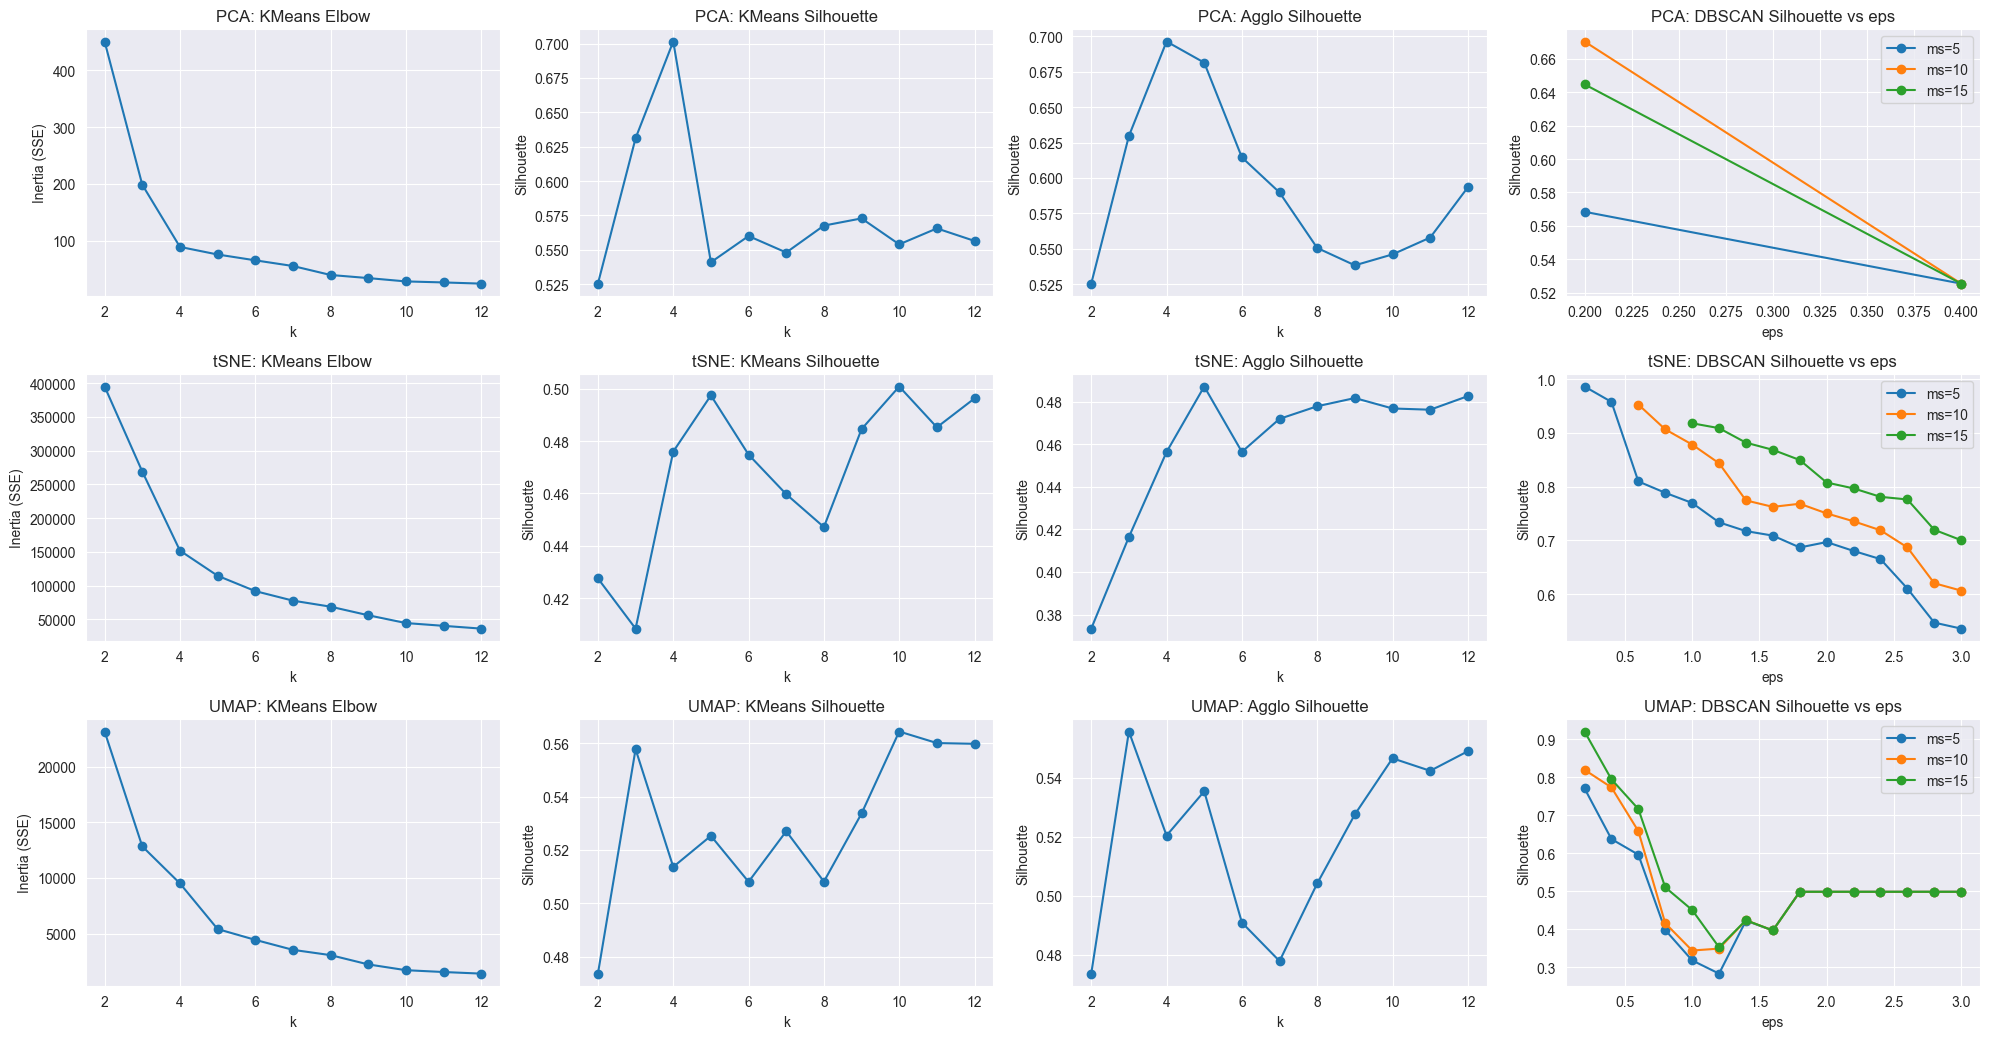

In [14]:
import numpy as np
import matplotlib.pyplot as plt

spaces = list(X_spaces.keys())
nrows = len(spaces)
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.5*nrows))
if nrows == 1:
    axes = np.array([axes])

for i, space_name in enumerate(spaces):
    km_res = diagnosticsSpace[(space_name, "KMeans")]
    ax = axes[i, 0]
    ax.plot(km_res["ks"], km_res["inertias"], marker="o")
    ax.set_title(f"{space_name}: KMeans Elbow")
    ax.set_xlabel("k")
    ax.set_ylabel("Inertia (SSE)")
    ax.grid(True)

    ax = axes[i, 1]
    ax.plot(km_res["ks"], km_res["sils"], marker="o")
    ax.set_title(f"{space_name}: KMeans Silhouette")
    ax.set_xlabel("k")
    ax.set_ylabel("Silhouette")
    ax.grid(True)

    ag_res = diagnosticsSpace[(space_name, "Agglomerative")]
    ax = axes[i, 2]
    ax.plot(ag_res["ks"], ag_res["sils"], marker="o")
    ax.set_title(f"{space_name}: Agglo Silhouette")
    ax.set_xlabel("k")
    ax.set_ylabel("Silhouette")
    ax.grid(True)

    grid = diagnosticsSpace[(space_name, "DBSCAN_grid")].copy()
    grid = grid.dropna(subset=["silhouette"])

    ax = axes[i, 3]
    if len(grid) == 0:
        ax.text(0.5, 0.5, "No valid DBSCAN silhouette\n(try wider eps grid)",
                ha="center", va="center")
        ax.set_axis_off()
    else:
        for ms in sorted(grid["min_samples"].unique()):
            sub = grid[grid["min_samples"] == ms].sort_values("eps")
            ax.plot(sub["eps"], sub["silhouette"], marker="o", label=f"ms={ms}")

        ax.set_title(f"{space_name}: DBSCAN Silhouette vs eps")
        ax.set_xlabel("eps")
        ax.set_ylabel("Silhouette")
        ax.grid(True)
        ax.legend()

plt.tight_layout()
plt.show()

## Применим кластеризацию к данным без уменьшенной размерности

In [15]:
results = []
diagnostics = {}

km_res = eval_kmeans(X_enc, 2, 12)
results.append({
    "algo": "KMeans",
    "best_param": km_res["best_k"],
    "silhouette": km_res["best_silhouette"],
})
diagnostics["KMeans"] = km_res

ag_res = eval_agglo(X_enc, 2, 12)
results.append({
    "algo": "Agglomerative",
    "best_param": ag_res["best_k"],
    "silhouette": ag_res["best_silhouette"],
})
diagnostics["Agglomerative"] = ag_res

db_best, db_grid = eval_dbscan(X_enc, eps_grid=np.linspace(0.2, 3.0, 15), min_samples_grid=(5, 10, 15))
results.append({
    "algo": "DBSCAN",
    "best_param": None if db_best is None else f"eps={db_best['eps']}, ms={db_best['min_samples']}",
    "silhouette": None if db_best is None else db_best["silhouette"],
    "n_clusters": None if db_best is None else db_best["n_clusters"],
    "noise_frac": None if db_best is None else db_best["noise_frac"],
})
diagnostics["DBSCAN_grid"] = db_grid

summary = pd.DataFrame(results).sort_values(["algo", "silhouette"], ascending=[True, False])
summary

,algo,best_param,silhouette,n_clusters,noise_frac
1,Agglomerative,12,0.211768,NaN,NaN
2,DBSCAN,"eps=0.4, ms=15",0.732973,11.0,0.592
0,KMeans,12,0.240929,NaN,NaN


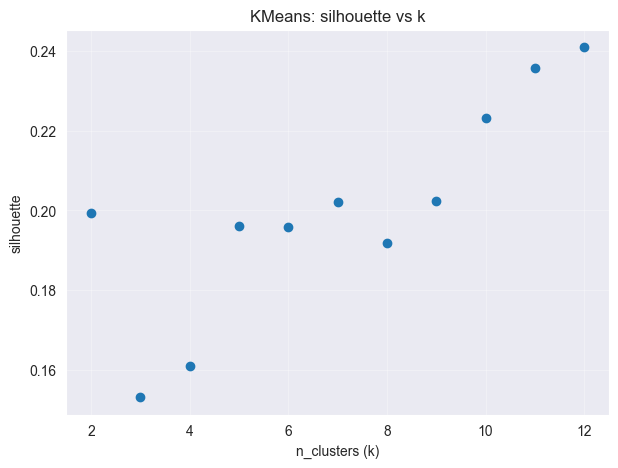

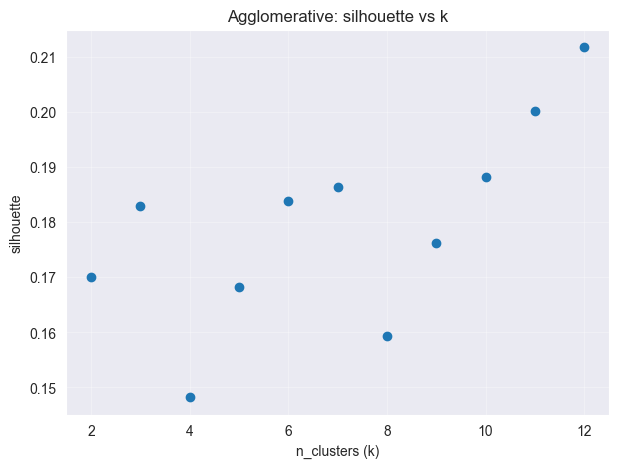

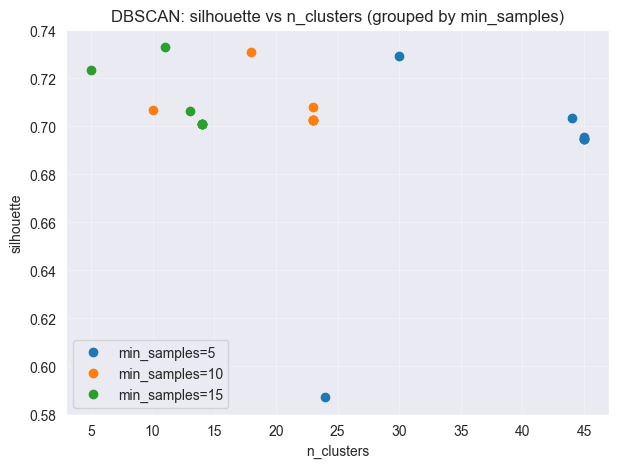

In [16]:
def plot_sil_vs_k_dict(ds, title):
    x = np.array(ds["sils"], dtype=float)
    y = np.array(ds["ks"], dtype=float)
    m = ~np.isnan(x)

    plt.figure(figsize=(7, 5))
    plt.plot(y[m], x[m], "o")
    plt.title(title)
    plt.xlabel("n_clusters (k)")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_dbscan(df, title):
    df = df.dropna(subset=["silhouette", "n_clusters"]).copy()

    plt.figure(figsize=(7, 5))

    for ms, g in df.groupby("min_samples"):
        plt.plot(g["n_clusters"], g["silhouette"], "o", label=f"min_samples={ms}")

    plt.title(title)
    plt.xlabel("n_clusters")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

if "KMeans" in diagnostics and isinstance(diagnostics["KMeans"], dict):
    plot_sil_vs_k_dict(diagnostics["KMeans"], "KMeans: silhouette vs k")

if "Agglomerative" in diagnostics and isinstance(diagnostics["Agglomerative"], dict):
    plot_sil_vs_k_dict(diagnostics["Agglomerative"], "Agglomerative: silhouette vs k")

if "DBSCAN_grid" in diagnostics and isinstance(diagnostics["DBSCAN_grid"], pd.DataFrame):
    plot_dbscan(diagnostics["DBSCAN_grid"], "DBSCAN: silhouette vs n_clusters (grouped by min_samples)")

# Интерпретация кластеров

Далее **интерпретируем получившиеся кластеры** в терминах *исходных признаков* (в исходных единицах измерения).



In [17]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

k_km = int(km_res["best_k"])
labels_kmeans = KMeans(n_clusters=k_km, random_state=42, n_init="auto").fit_predict(X_enc)

k_ag = int(ag_res["best_k"])
labels_agglo = AgglomerativeClustering(n_clusters=k_ag).fit_predict(X_enc)

labels_dbscan = None
if db_best is not None:
    eps_best = float(db_best["eps"])
    ms_best = int(db_best["min_samples"])
    labels_dbscan = DBSCAN(eps=eps_best, min_samples=ms_best).fit_predict(X_enc)

cluster_labels = {
    f"KMeans (k={k_km})": labels_kmeans,
    f"Agglomerative (k={k_ag})": labels_agglo,
}
if labels_dbscan is not None:
    cluster_labels[f"DBSCAN (eps={eps_best}, min_samples={ms_best})"] = labels_dbscan


interpret_num_cols = num_cols
interpret_cat_cols = cat_cols

In [19]:
def _clusters_to_show(labels, max_clusters=10, keep_noise=True):
    s = pd.Series(labels, name="cluster")
    counts = s.value_counts(dropna=False)

    cl_all = counts.index.tolist()
    cl_main = [c for c in cl_all if c != -1]

    if len(cl_main) > max_clusters:
        cl_main = counts.drop(index=[-1], errors="ignore").head(max_clusters).index.tolist()

    if keep_noise and (-1 in cl_all):
        cl_main = cl_main + [-1]

    return cl_main, counts

def interpret_clusters(df_raw, labels, num_cols, cat_cols, name, max_clusters=10, keep_noise=True):
    dfi = df_raw[num_cols + cat_cols].copy()
    dfi["cluster"] = labels

    clusters, counts = _clusters_to_show(labels, max_clusters=max_clusters, keep_noise=keep_noise)
    dfi = dfi[dfi["cluster"].isin(clusters)].copy()

    # --- размер кластеров ---
    plt.figure(figsize=(7, 4))
    counts_show = counts.loc[clusters]
    counts_show.index = counts_show.index.astype(str)
    counts_show.plot(kind="bar")
    plt.title(f"{name}: cluster sizes (shown clusters)")
    plt.xlabel("cluster")
    plt.ylabel("count")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

    num_mean = dfi.groupby("cluster")[num_cols].mean().round(2)
    num_median = dfi.groupby("cluster")[num_cols].median().round(2)

    display(pd.DataFrame({"size": dfi["cluster"].value_counts().sort_index()}))
    display(num_mean)
    display(num_median)

    sep_rows = []
    for col in num_cols:
        x = dfi[col].astype(float)
        total_var = x.var()
        if total_var == 0 or np.isnan(total_var):
            sep = np.nan
        else:
            g = dfi.groupby("cluster")[col].mean()
            n = dfi.groupby("cluster")[col].count()
            overall = x.mean()
            between = (n * (g - overall) ** 2).sum() / n.sum()
            sep = float(between / total_var)
        sep_rows.append((col, sep))

    sep_df = pd.DataFrame(sep_rows, columns=["feature", "between_var_ratio"]).sort_values("between_var_ratio", ascending=False)
    display(sep_df)

    for col in cat_cols:
        dist = (
            dfi.groupby("cluster")[col]
               .value_counts(normalize=True)
               .rename("share")
               .reset_index()
               .sort_values(["cluster", "share"], ascending=[True, False])
        )
        top = dist.groupby("cluster").head(3).copy()
        top["share"] = (top["share"] * 100).round(1).astype(str) + "%"
        print(f"\n{name}: top categories for '{col}' (top-3 per cluster)")
        display(top)

    clusters_sorted = sorted([c for c in clusters if c != -1]) + ([-1] if (-1 in clusters) else [])
    cluster_labels_str = [str(c) for c in clusters_sorted]

    for col in num_cols:
        data = [dfi.loc[dfi["cluster"] == c, col].dropna().values for c in clusters_sorted]
        plt.figure(figsize=(8, 4))
        plt.boxplot(data, labels=cluster_labels_str, showfliers=False)
        plt.title(f"{name}: boxplot of '{col}' by cluster")
        plt.xlabel("cluster")
        plt.ylabel(col)
        plt.grid(True, axis="y", alpha=0.3)
        plt.show()


,model,n_clusters,noise_frac,silhouette(X_enc)
2,"DBSCAN (eps=0.4, min_samples=15)",11,0.592,0.732973
0,KMeans (k=12),12,0.000,0.240929
1,Agglomerative (k=12),12,0.000,0.211768


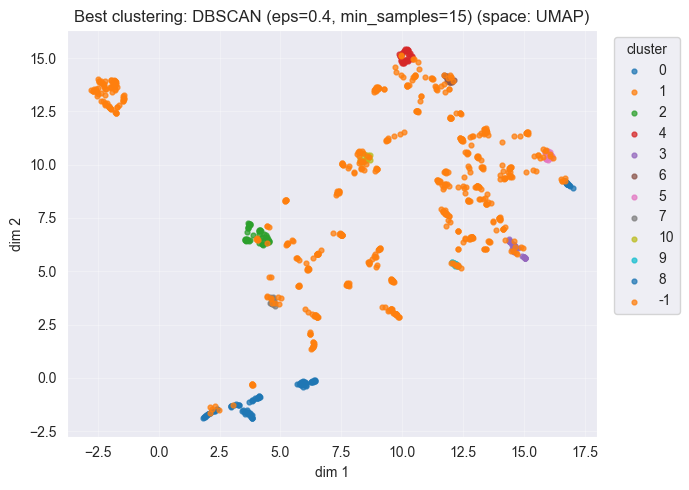

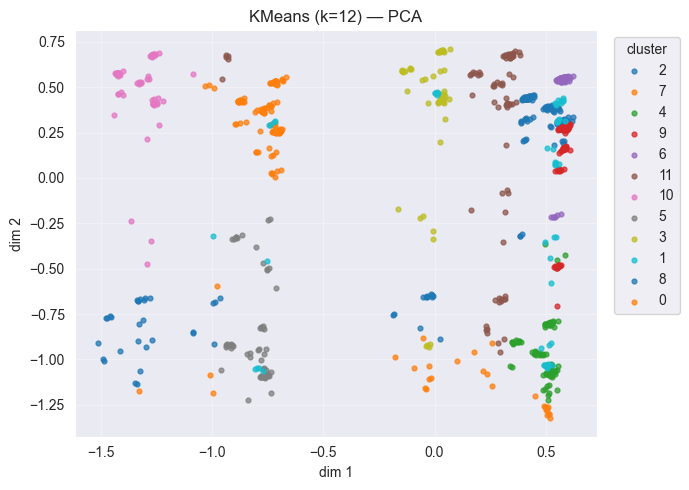

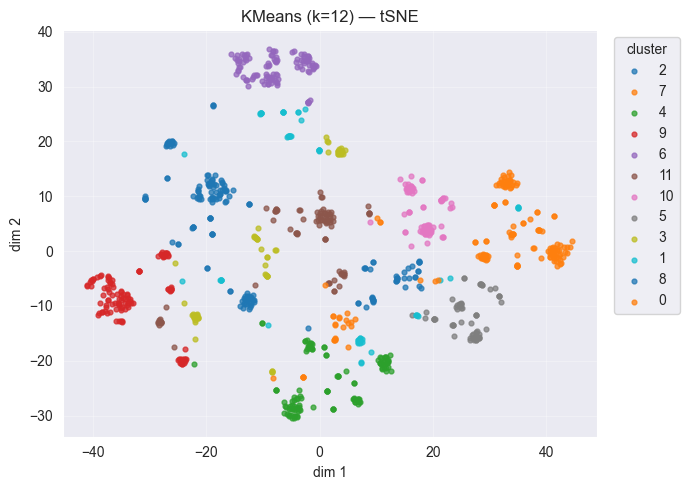

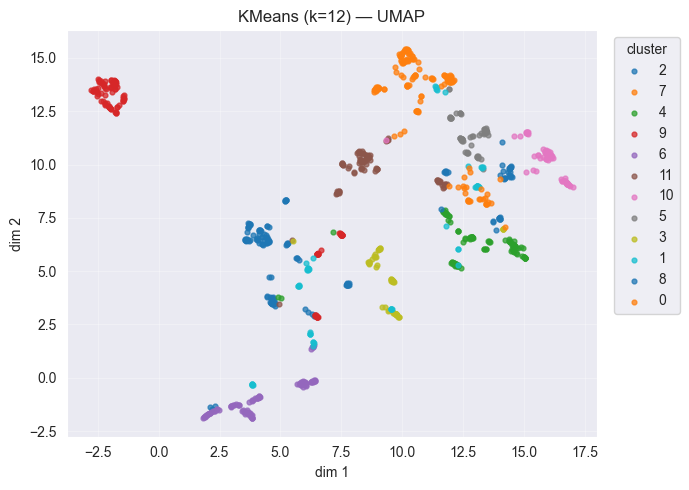

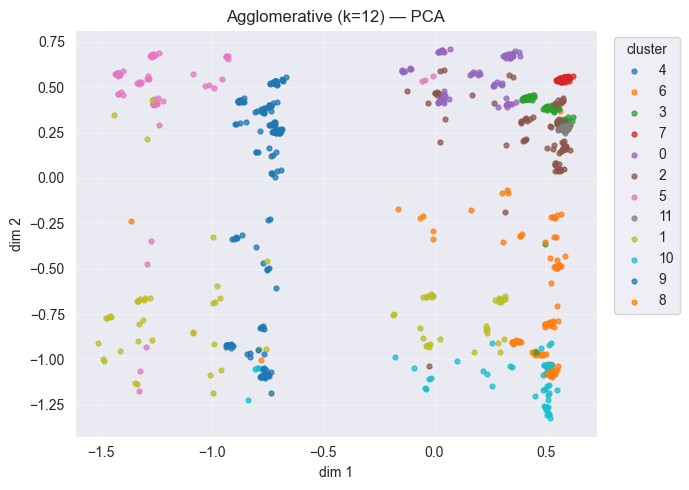

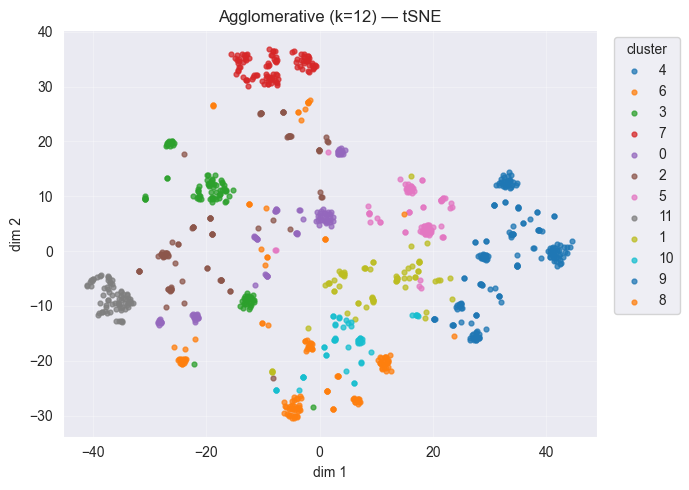

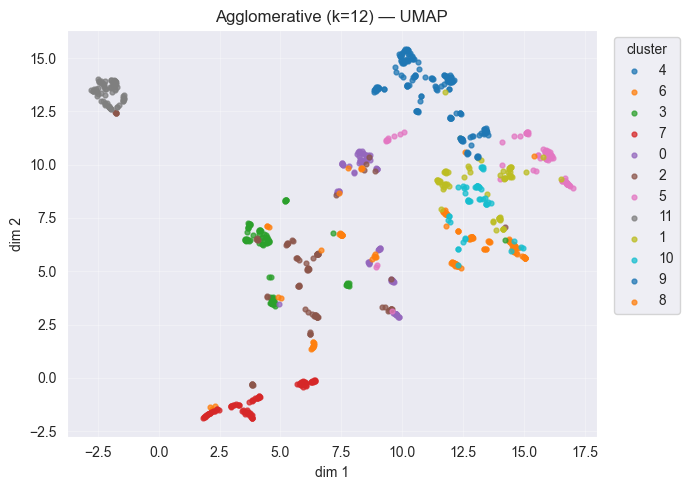

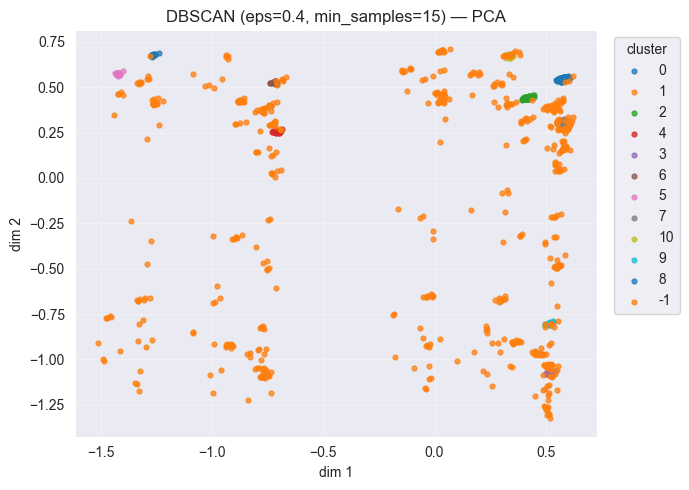

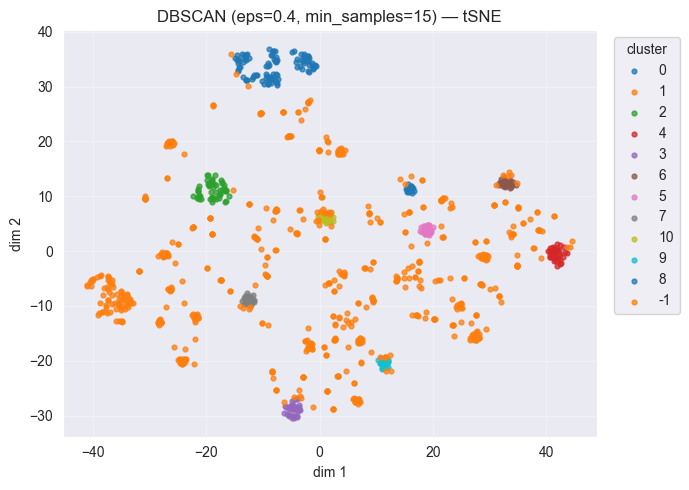

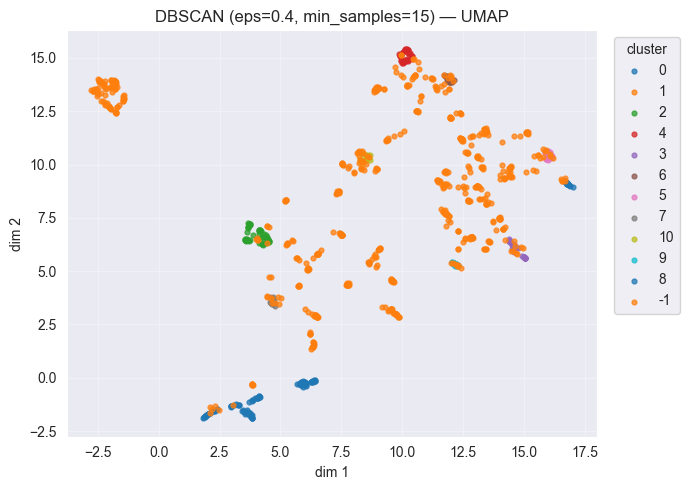

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def _n_clusters_noise(labels):
    labels = np.asarray(labels)
    uniq = set(labels.tolist())
    n_clusters = len(uniq) - (1 if -1 in uniq else 0)
    noise_frac = float(np.mean(labels == -1)) if len(labels) else 0.0
    return int(n_clusters), noise_frac

def plot_clusters_2d(X2, labels, title, max_clusters=12):
    labels = np.asarray(labels)

    vc = pd.Series(labels).value_counts()
    main = vc.index.tolist()

    if -1 in main:  # noise у DBSCAN
        main_no_noise = [c for c in main if c != -1]
        main = main_no_noise[:max_clusters] + [-1]
    else:
        main = main[:max_clusters]

    plt.figure(figsize=(7, 5))
    for cl in main:
        m = labels == cl
        plt.scatter(X2[m, 0], X2[m, 1], s=12, alpha=0.75, label=str(cl))

    plt.title(title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.grid(True, alpha=0.3)
    plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

if "X_spaces" not in globals():
    X_spaces = {"PCA": X_pca2, "UMAP": X_umap2, "tSNE": X_tsne2}

if "cluster_labels" not in globals():
    cluster_labels = {}
    if "labels_kmeans" in globals():
        cluster_labels[f"KMeans (k={k_km})"] = labels_kmeans
    if "labels_agglo" in globals():
        cluster_labels[f"Agglomerative (k={k_ag})"] = labels_agglo
    if "labels_dbscan" in globals() and labels_dbscan is not None:
        cluster_labels["DBSCAN"] = labels_dbscan

rows = []
for name, labels in cluster_labels.items():
    if labels is None:
        continue

    n_clusters, noise_frac = _n_clusters_noise(labels)

    sil = None
    if "safe_silhouette" in globals():
        sil = safe_silhouette(X_enc, labels)

    rows.append({
        "model": name,
        "n_clusters": n_clusters,
        "noise_frac": noise_frac,
        "silhouette(X_enc)": sil,
    })

summary_df = pd.DataFrame(rows).sort_values("silhouette(X_enc)", ascending=False, na_position="last")
display(summary_df)

if len(summary_df):
    best_name = summary_df.iloc[0]["model"]
    best_labels = cluster_labels[best_name]

    space_order = ["UMAP", "tSNE", "PCA"]
    space_name = next((s for s in space_order if s in X_spaces), list(X_spaces.keys())[0])

    plot_clusters_2d(X_spaces[space_name], best_labels, f"Best clustering: {best_name} (space: {space_name})")


    for algo_name, labels in cluster_labels.items():
        for sp, X2 in X_spaces.items():
            plot_clusters_2d(X2, labels, f"{algo_name} — {sp}")


# Выводы

После проведенного *EDA* были протестированы KMeans, Agglomerative Clustering и DBSCAN.
Подбор параметров выполнялся по метрике силуета на пространстве признаков X_enc. Наилучшее значение силуета показал dbscan при eps=0.4 и min_samples=15: алгоритм выделил 11 кластеров и отнёс около 59% наблюдений к шуму.

Высокое значение силуета (*0.73*) у DBSCAN отражает хорошую разделимость именно “ядра” кластеров, при этом существенная доля объектов не образует устойчивых плотных групп и остаётся вне кластеров. KMeans и Agglomerative при k=12 дали низкие значения силуета (*~0.21–0.24*), что указывает на слабую отделимость кластеров при принудительном разбиении всей выборки. Визуализация UMAP подтверждает вывод: присутствуют несколько компактных сегментов и большая "диффузная" область без чётких границ, поэтому DBSCAN лучше подходит для выявления локальных плотных групп, тогда как KMeans/Agglomerative хуже отражают структуру данных.